Sensitivity analysis, including a linear regression model, SOBOL, and Extra-Trees analysis. Code copied from assignment 6 model answers.

In [1]:
#First load the necessary libraries and functions
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome,
                           perform_experiments, MultiprocessingEvaluator, ema_logging,Policy)

from ema_workbench import Samplers

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

from SALib.analyze import sobol

In [2]:
#Load the model
from problem_formulation import get_model_for_problem_formulation

In [3]:
#Choose problem formulation 4 to get results disaggregated over time
ema_logging.log_to_stderr(ema_logging.INFO)
dike_model, planning_steps = get_model_for_problem_formulation(4)

In [4]:
# Model Uncertainties
for uncertainty in dike_model.uncertainties:
    print(repr(uncertainty))

uncertainties = dike_model.uncertainties

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [5]:
# Amaryllis: Trying to make some own policies

def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


#RFR in Doesburg and Zuthpen as they talked about in the debate
policy_rfr_A1_A3 = Policy(
        "policy RfR in A1 and A3",
        **dict(
            get_do_nothing_dict(),
            **{"1_RfR 0": 1, "1_RfR 1": 1, "1_RfR 2": 1,
               "3_RfR 0": 1, "3_RfR 1": 1, '3_RfR 2': 1,}
        )
    )

#RFR in Doesburg and Zuthpen and dike heightening in Cortenoever and Gorssel
policy_rfr_A1_A3_dike_A2_A4= Policy(
        "policy RfR in A1 and A3 and Dike height in A2 and A4",
        **dict(
            get_do_nothing_dict(),
            **{# RfR for A1
            "1_RfR 0": 1, "1_RfR 1": 1, "1_RfR 2": 1,
            # RfR for A3
            "3_RfR 0": 1, "3_RfR 1": 1, "3_RfR 2": 1,
            # DikeIncrease for A2
           # "2_DikeIncrease 0": 5, "2_DikeIncrease 1": 5, "2_DikeIncrease 2": 5,
            # DikeIncrease for A4
            "4_DikeIncrease 0": 5, "4_DikeIncrease 1": 5, "4_DikeIncrease 2": 5,}
        )
    )

#some random policies
import random
from ema_workbench import Policy

def generate_random_policy(name):
    lever_values = {}
    for lever in dike_model.levers:
        if "RfR" in lever.name:
            # RfR levers: either 0 or 1
            lever_values[lever.name] = random.choice([0, 1])
        elif "DikeIncrease" in lever.name:
            # DikeIncrease levers: 0 to 10
            lever_values[lever.name] = random.randint(0, 10)
        else:
            # other levers if any - set to 0 or default
            lever_values[lever.name] = 0
    return Policy(name, **lever_values)

# Create policies 4 to 10
random_policies = [generate_random_policy(f"random policy {i}") for i in range(4, 11)]


policies = [
    Policy("do nothing", **get_do_nothing_dict()),
    policy_rfr_A1_A3,
    policy_rfr_A1_A3_dike_A2_A4,
] + random_policies

In [6]:
#Number of linear regression model experiments, in assignment 6: n_exp = 1000
n_exp = 160

with MultiprocessingEvaluator(dike_model) as evaluator:
    results_lhs = evaluator.perform_experiments(scenarios=n_exp, policies = policies, uncertainty_sampling=Samplers.LHS)

exp_lhs, out_lhs = results_lhs

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 160 scenarios * 10 policies * 1 model(s) = 1600 experiments
100%|██████████████████████████████████████| 1600/1600 [09:54<00:00,  2.69it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [7]:
out_lhs['Minimum Water Level'].shape

(1600, 3, 30)

In [8]:
out_lhs['Minimum Water Level'][:,0,-1]

array([4.5387    , 4.5387    , 5.14018143, ..., 4.5387    , 4.5387    ,
       4.5387    ])

In [9]:
#Getting the results of the linear regression model run outocomes
min_wl_final_lhs = out_lhs['Minimum Water Level'][:,0,-1]
min_wl_mean_lhs = np.mean(out_lhs['Minimum Water Level'][:,0,:],axis=1)
min_wl_std_lhs = np.std(out_lhs['Minimum Water Level'][:,0,:],axis=1)

In [10]:
#Make the linear regression
import statsmodels.api as sm

X = pd.DataFrame(exp_lhs).drop(['model','policy'], inplace=False, axis=1)
X_0 = sm.add_constant(X)

est = sm.OLS(min_wl_final_lhs, X_0.astype(float)).fit()
print(est.summary())
print(est.params)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     15.71
Date:                Thu, 05 Jun 2025   Prob (F-statistic):           1.28e-65
Time:                        23:01:24   Log-Likelihood:                -729.21
No. Observations:                1600   AIC:                             1516.
Df Residuals:                    1571   BIC:                             1672.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

P>|t| values shows the statistical significance, with a lower value being more significant. Parameters with values of 0 or close to 0 are important

In [11]:
problem = get_SALib_problem(uncertainties)
print(problem)

{'num_vars': 19, 'names': ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1', 'discount rate 2'], 'bounds': [(0, 133), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (0, 4), (0, 4), (0, 4)]}


Next up SOBOL. Running it will take a while.

In [ ]:
n_exp = 8

with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments_sobol, outcomes_sobol = perform_experiments(dike_model, scenarios=n_exp,
                                                            policies=policies,
                                                            uncertainty_sampling=Samplers.SOBOL)

min_wl_final_sobol = outcomes_sobol['Minimum Water Level'][:,0,-1]
min_wl_mean_sobol = np.mean(outcomes_sobol['Minimum Water Level'][:,0,:],axis=1)
min_wl_std_sobol = np.std(outcomes_sobol['Minimum Water Level'][:,0,:],axis=1)

Si = sobol.analyze(problem, min_wl_mean_sobol, calc_second_order=True, print_to_console=True)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 320 scenarios * 10 policies * 1 model(s) = 3200 experiments
  4%|█▍                                     | 116/3200 [01:12<38:30,  1.33it/s]

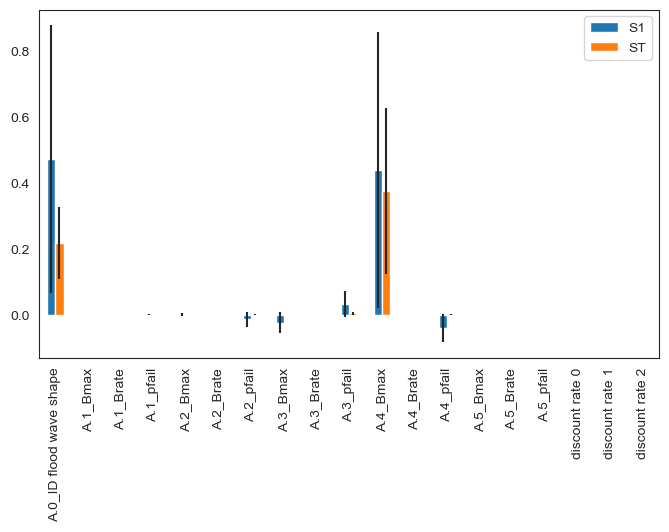

In [24]:
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [ ]:
Y = min_wl_mean_sobol

s_data = pd.DataFrame(index=problem['names'],
                      columns=np.arange(20,n_exp,50)*(2*problem['num_vars']+2))
for j in s_data.columns:
    scores = sobol.analyze(problem, Y[0:j], calc_second_order=True, print_to_console=False)
    s_data.loc[:,j] = scores['ST']

In [ ]:
fig, ax = plt.subplots(1)

s_data.T.plot(ax=ax)
ax.set_xlabel('Samples')
ax.set_ylabel('Total index (ST)')
plt.show()

In [25]:
from ema_workbench.analysis import feature_scoring

In [43]:
cleaned_experiments_sobol = experiments_sobol.drop(columns=[l.name for l in dike_model.levers])

In [44]:
scores = feature_scoring.get_ex_feature_scores(cleaned_experiments_sobol, min_wl_final_sobol,
                                      max_features=0.6, mode=RuleInductionType.REGRESSION)[0]
scores

,1
0,
policy,0.445126
A.0_ID flood wave shape,0.387322
A.4_Bmax,0.049062
A.4_Brate,0.017767
A.5_pfail,0.014784
A.2_Bmax,0.010358
discount rate 1,0.010134
A.4_pfail,0.009509
A.3_Bmax,0.006348


In [45]:
combined_scores = []
for j in range(100, experiments_sobol.shape[0], 100):
    scores = feature_scoring.get_ex_feature_scores(cleaned_experiments_sobol.iloc[0:j, :],
                                                   min_wl_mean_sobol[0:j],
                                                   max_features=0.6,
                                                   mode=RuleInductionType.REGRESSION)[0]
    scores.columns = [j]
    combined_scores.append(scores)

In [46]:
combined_scores = pd.concat(combined_scores, axis=1, sort=True)

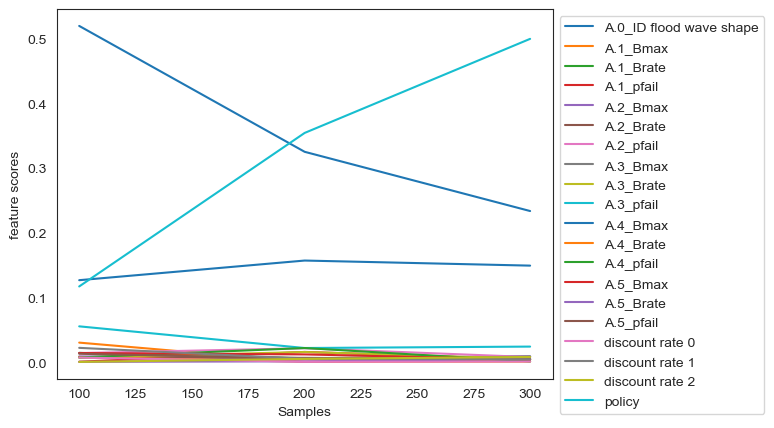

In [47]:
fig, ax = plt.subplots(1)

combined_scores.T.plot(ax=ax)
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('Samples')
ax.set_ylabel('feature scores')
plt.show()